____

**project**: `Animal Image Recognition (AIR)`

**date**: `2022-12-09`

**decription**: `Given an image of an animal amoung the 10 animals in the dataset, the model must be able to accuratetly classify the class of that animal.`.

**main**: `computer vision(cv) pytorch`

**programmer**: `crispengari`

**architecture**:  `AlexNet`

**language**: `python`
____


### AIR Model

In this notebook I will train a computer vision model using deep learning technologies to classify the class the animal belongs to among the `10` that exists.  We are going to use the dataset that comes from [kaggle](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset) the V2 which consist of 10 image classes.

![alt](https://storage.googleapis.com/kaggle-datasets-images/2610296/4573409/55cbd6980d8db247f28a4b5ccbf1bd3f/dataset-cover.jpg?t=2022-12-06-06-10-41)

### Problem Statement
"Children at the age of `3-5` need to have been facing challanges in identifying different animals of the world. With the help of AI models these kids can easily learn to identify animals and learn from AI."

In this project i will build an animal classifier model that will be able to classify the name of a given animal among the `10` that exists.


### Data
In this notebook I will train a simple animal classifier model  using the dataset that was obtained from [kaggle](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset).

### Model Architecture
In this notebook I will create a image clasifier model that will classify `10` diffent animals. So basically this is a multi-class classification problem i will solve by creating an deep learning modl using the  `AlexNet` achitecture. I will use [this notebook](https://github.com/CrispenGari/cv-torch/blob/main/00-GENDER-CLASSIFICATION/01_Gender_Classification.ipynb) as reference and some previously used notebooks.


### Animal Classes
The following are the different `10` classes of animals that we are going to classify:
```
- Cat
- Cow
- Dog
- Elephant
- Gorilla
- Hippo
- Monkey
- Panda
- Tiger
- Zebra
```


### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.


In [ ]:
pip install helperfns -q

### Imports
In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torchvision

import random, time, os, copy, shutil
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

from sklearn import decomposition, manifold
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string


torch.__version__

'1.13.0+cu116'

### Seed
In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.

In [ ]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
Get the `gpu` as our device if possible for training speed.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

As I mentioned the dataset that we are going to use is from `kaggle` we need a way of downloading and extracting it from `kaggle`. I will follow the steps that I listed on one of my previous notebooks [05_ResNet.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb).

In [ ]:
!pip install kaggle -q

In [ ]:
os.environ["KAGGLE_USERNAME"]="YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_API_KEY"

In [ ]:
!kaggle datasets download utkarshsaxenadn/animal-image-classification-dataset --unzip

100% 1.61G/1.61G [01:26<00:00, 24.1MB/s]
100% 1.61G/1.61G [01:26<00:00, 20.0MB/s]


To handle our dataset we are going to use the torch-vision class called `dataset.ImageFolder` and it expect the folder structure looks as follows:

```
root
  - classx
    - x.png
    - x.jpg
  ....

  - classy
    - y.png
    - y.jpg
```
This is exactly how our images are grouped in the `Animal-Data-V2/Data-V2` folder. Our dataset have all the `3` sets so we don't need to do the splitting of examples to generate sets.


Next we are going to define the paths to where our datasets are stored.

In [ ]:
BASE_DIR = 'Animal-Data-V2/Data-V2'

train_dir = os.path.join(BASE_DIR, 'Training Data')
test_dir = os.path.join(BASE_DIR, 'Testing Data')
valid_dir = os.path.join(BASE_DIR, 'Validation Data')

#### Normalizing the dataset
> The idea of data normalization is an general concept that refers to the act of transforming the original values of a dataset to new values. - `deeplizard`

We use normalization for feature scalling. `Standadization` is an example of normalization it is sometimes called `z-score` normalization. So we need to normalize our dataset but first of all we need to calculate the mean and starndard deviations for each chanels in the training set so that when we call the `transforms.Normalize()` we pass the `mean` and `standard deviations` for each channel

```py
torchvision.transforms.Normalize(
      [meanOfChannel1, meanOfChannel2, meanOfChannel3] 
    , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
)
```
So which means we need to manually with code calculate the means and std values for each channel in our train set.



In [ ]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform= transforms.ToTensor()
)

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
  means += torch.mean(img, dim = (1, 2))
  stds += torch.std(img, dim = (1, 2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.5059, 0.4904, 0.4246])
Calculated stds: tensor([0.2292, 0.2269, 0.2292])


### Image Transformations

In the following code cell we are going to define the image transformations for all the `3` sets which are `train`,`test` and `validation`

In [ ]:
image_transforms = {
    "training": transforms.Compose([
       transforms.Resize([224,224]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.ToTensor(),
       transforms.Normalize(mean=means, std=stds, inplace=False)                         
    ]),
    "validation": transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds, inplace=False)
    ]),
    "testing": transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds, inplace=False)
    ])
}

### Loading our custom Data

In the following code cell we are then going to load our custom data using the `ImageFolder` class from `torchvision` with custom transforms.

In [ ]:
image_datasets = {
    _set: datasets.ImageFolder(
        _path,
        transform = image_transforms[_set]
    ) for _set, _path in zip(["training", 'validation', 'testing'], [train_dir, test_dir, valid_dir])
}

### Classes
In the following code cell we are going to get all the classes that we have in our dataset.

In [ ]:
class_names = image_datasets["training"].classes
print(class_names)

['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Monkey', 'Panda', 'Tiger', 'Zebra']


Checking the image shape of a single image in our dataset

In [ ]:
image_datasets["training"][0][0].shape

torch.Size([3, 224, 224])

Getting the datasets from `3` different sets.

In [ ]:
train_data = image_datasets["training"]
val_data = image_datasets["validation"]
test_data = image_datasets["testing"]

### Checking examples
In the following code cell we are going to count how many examples we are having from our dataset.

In [ ]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)), 
             ("testing", len(test_data)), 
             ("validation", len(val_data)),
             ("total", f"{len(val_data) + len(test_data) + len(train_data):,}")
        ]

tabulate_data(columns, data_rows, title)

+---------------------+
|  DATASETS EXAMPLES  |
+------------+--------+
| SET        |  TOTAL |
+------------+--------+
| training   |  20000 |
| testing    |   1000 |
| validation |   1907 |
| total      | 22,907 |
+------------+--------+


### Iterator
In the following code cell we are then going to create an `iterator` with the batchsize of `128`

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE,  num_workers=5, pin_memory=True
)

valid_iterator = data.DataLoader(
    val_data, batch_size= BATCH_SIZE,  num_workers=5, pin_memory=True
)

test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE,  num_workers=5, pin_memory=True
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualizing Images
Now we can go ahead and visualize the images that we are having in this dataset.

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In the following code cell we are going to define a function that will plot the normalised images from our datasets.

In [ ]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.axis('off')

In [ ]:
images, labels = next(iter(train_iterator))

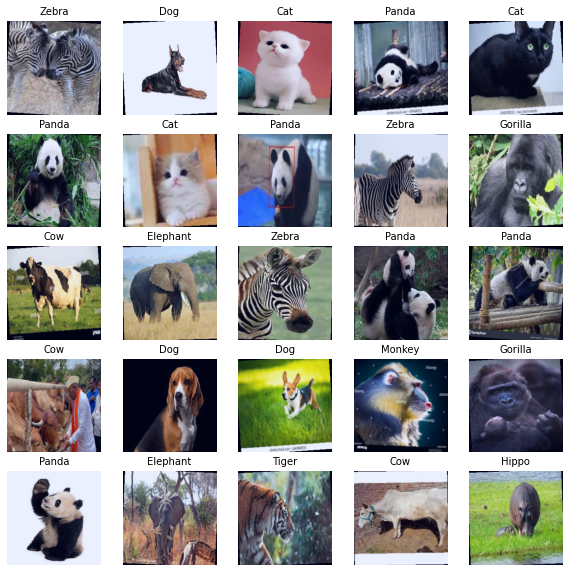

In [ ]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in 
                           [list(zip(images, labels))[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

### Defining Model
In the following code cell we are going to define our model using the `AlexNet` achitecture that will do image classifications for our `10` classes of animals.



In [ ]:

IMG_WIDTH = IMG_HEIGHT = 224

class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super(AlexNet, self).__init__()
    self._to_linear = None
    self.x = torch.randn(3, IMG_WIDTH, IMG_HEIGHT).view(-1, 3, IMG_WIDTH, IMG_HEIGHT)
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3, 2, 1), # in_channels, out_channels, kernel_size, stride, padding
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True), 
        nn.Conv2d(192, 384, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 512, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 256, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True)
  )
    self.conv(self.x)
    self.classifier = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(self._to_linear, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, output_dim),
    )

  def conv(self, x):
    x = self.features(x)
    if self._to_linear is None:
      self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
    return x

  def forward(self, x):
    x = self.conv(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

### Model Instance

In the following code cell we are going to create a model instance of our classifier model.

In [ ]:
OUTPUT_DIM = len(class_names)
model = AlexNet(OUTPUT_DIM).to(device)
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544

### Counting model Parameters
In the following code cell we are going to count the `model` parameters of our model.

In [ ]:
models.model_params(model)

TOTAL MODEL PARAMETERS: 	71,933,002
TOTAL TRAINABLE PARAMETERS: 	71,933,002


### Model Training
In the following code cell we are going to create create `optimizer` and `criterion`and put the model and optimizer to the `device`. Note that for the optimizer we are going to use the `Adam` with default parameters and `CrossEntropyLoss` as our loss function since it is a multi-class classification.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

### Categorical Accuracy Function.
In the following code cell we are going to define our categorical loss function.

In [ ]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluation Function
In the following code cell we are going to define our `train` and evaluation functions.

In [ ]:

def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

###Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `50` epochs.

In [ ]:
EPOCHS = 50
best_valid_loss = float('inf')
MODEL_NAME = "animal-image-recognition.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  
  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)

+--------------------------------------------+
|           EPOCH 01/50: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 2.216 |   19.57% | 0:01:56.04 |
| Validation | 1.674 |   40.99% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|           EPOCH 02/50: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.725 |   37.75% | 0:01:40.78 |
| Validation | 1.497 |   44.20% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|           EPOCH 03/50: (saving)            |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      

### Model Evaluation

In [ ]:
model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.571 |   82.34% |            |
+------+-------+----------+------------+


### Downloading the best model
We are going to download the saved model as a file in the following code cell.

In [ ]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Inference
For model inference we are going to take in an image and make predictions on it.

### Image preprocessing
For image preprocessing we are going to use `torchvision` transforms so we are basically going to use the `test_transforms` which looks as follows:

```py
transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds, inplace=False)
])
```

In [ ]:
from PIL import Image

In [ ]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  img = image_transforms['testing'](img)
  return img

In [ ]:
img_path = os.path.join('Animal-Data-V2/Data-V2', "Testing Data/Cat/cat-test (1).jpeg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method
The predict method will take in the following args:

1. model
2. image (processed image)
3. device (cuda or cpu)

In [ ]:
class Prediction:
    def __init__(self, label:int, probability:float, class_name: str) -> None:
        self.label = label
        self.probability = probability
        self.class_name = class_name
        
    def __repr__(self) -> str:
        return f"<{self.class_name}>"
    
    def __str__(self) -> str:
        return f"<{self.class_name}>"
    
    def to_json(self):
        return {
            "label": int(self.label),
            "probability": float(self.probability),
            "class_name": self.class_name,
        }
    
class Response:
    def __init__(self, top_prediction: Prediction, predictions:list) -> None:
        self.predictions = predictions
        self.top_prediction = top_prediction
        
    def __repr__(self) -> str:
        return f"<SSI Prediction Response>"
    
    def __str__(self) -> str:
        return f"<SSI Prediction Response>"
    
    def to_json(self):
        return{
           "predictions": [item.to_json() for item in self.predictions],
            "top_prediction": self.top_prediction.to_json()
        }
    

In [ ]:
def predict(model, image, device):
    image = image.unsqueeze(dim=0).to(device)
    preds, _ = model(image)
    preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()
    predicted_label = np.argmax(preds)
    predictions = [
        Prediction(
            label = i,
            class_name = classes[i],
            probability = np.round(preds[i], 2)
        ) for i, _ in enumerate(preds)
    ]
    predicted = Prediction(
        label = predicted_label,
        class_name = classes[predicted_label],
        probability = np.round(preds[predicted_label], 2)
    )
    return Response(
        top_prediction = predicted,
        predictions = predictions
    )
predict(model, img, device).to_json()

{'predictions': [{'label': 0,
   'probability': 0.9800000190734863,
   'class_name': 'Cat'},
  {'label': 1, 'probability': 0.0, 'class_name': 'Cow'},
  {'label': 2, 'probability': 0.019999999552965164, 'class_name': 'Dog'},
  {'label': 3, 'probability': 0.0, 'class_name': 'Elephant'},
  {'label': 4, 'probability': 0.0, 'class_name': 'Gorilla'},
  {'label': 5, 'probability': 0.0, 'class_name': 'Hippo'},
  {'label': 6, 'probability': 0.0, 'class_name': 'Monkey'},
  {'label': 7, 'probability': 0.0, 'class_name': 'Panda'},
  {'label': 8, 'probability': 0.0, 'class_name': 'Tiger'},
  {'label': 9, 'probability': 0.0, 'class_name': 'Zebra'}],
 'top_prediction': {'label': 0,
  'probability': 0.9800000190734863,
  'class_name': 'Cat'}}